In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
basedir = "D:/Raphael/Data/3. Plasmid moves cargo into Lysosomes"
df = pd.read_excel(os.path.join(basedir,"Results.xlsx"))
df = df[df["Group2"]=="LAMP1"]
df.head()

,Unnamed: 0,label,bbox-0,bbox-1,bbox-2,bbox-3,label_aSyn-GFP,bbox-0_aSyn-GFP,bbox-1_aSyn-GFP,bbox-2_aSyn-GFP,...,Channel_1,Channel_aSyn-AB,Channel_2,Channel_LAMP1/LC3,ROI_path,Replicate,Group1,Group2,path,denoised_path
0,0,3,685,797,1413,1464,3,685,797,1413,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
1,1,1,504,721,1597,1402,1,504,721,1597,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
2,2,5,269,703,789,1193,5,269,703,789,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
3,3,6,589,716,1683,1388,6,589,716,1683,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...
4,4,3,628,1073,1351,1678,3,628,1073,1351,...,aSyn-AB,1,LAMP1/LC3,2,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,1,FY,LAMP1,D:/Raphael/Data/3. Plasmid moves cargo into Ly...,D:/Raphael/Data/3. Plasmid moves cargo into Ly...


In [3]:
from ImageOperations import get_cropped, getImage, get_mask, get_ROI
from Ripley import ripley
from DetectPoints import detect_points
from tqdm import tqdm
def get_R(lower,upper):
    xlen = 0.0753084
    r = np.linspace(lower/xlen,upper/xlen,100)
    return r

def calculate_ripley(df,R):
    data = {
        "L":[],
        "r":[],
        "X":[],
        "Y":[],
        "Group":[],
        "Stack":[],
        "CID":[],
        "Rep":[]
    }
    for CID in tqdm(df["CID"].values):
        rep = df[df["CID"]==CID]["Replicate"].values[0]
        g = df[df["CID"]==CID]["Group1"].values[0]
        ROI = get_ROI(df,CID)
        GFPimage = get_cropped(df,CID,0).astype("uint8")
        ABimage = get_cropped(df,CID,1).astype("uint8")
        LAMP1image = get_cropped(df,CID,2).astype("uint8")
        boundary = ROI.coordinates()-[[ROI.left,ROI.top]]
        for i in range(GFPimage.shape[0]):
            GFP = detect_points(GFPimage[i,:,:],ROI,ntol=5)
            AB = detect_points(ABimage[i,:,:],ROI,ntol=5)
            LAMP1 = detect_points(LAMP1image[i,:,:],ROI,ntol=3)
            #GFP - LAMP1
            if len(GFP) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*ripley(GFP,LAMP1,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["GFP"]*len(R))]
                data["Y"]=[*data["Y"],*(["LAMP1"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
            #AB - LAMP1
            if len(AB) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*ripley(AB,LAMP1,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["AB"]*len(R))]
                data["Y"]=[*data["Y"],*(["LAMP1"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
            #LAMP1 - GFP
            if len(GFP) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*ripley(LAMP1,GFP,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LAMP1"]*len(R))]
                data["Y"]=[*data["Y"],*(["GFP"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
            #LAMP1 - AB
            if len(AB) != 0 and len(LAMP1) != 0:
                data["L"]=[*data["L"],*ripley(LAMP1,AB,boundary,R,maxD=np.max(R))]
                data["r"]=[*data["r"],*R]
                data["X"]=[*data["X"],*(["LAMP1"]*len(R))]
                data["Y"]=[*data["Y"],*(["AB"]*len(R))]
                data["CID"]=[*data["CID"],*([CID]*len(R))]
                data["Rep"]=[*data["Rep"],*([rep]*len(R))]
                data["Group"]=[*data["Group"],*([g]*len(R))]
                data["Stack"]=[*data["Stack"],*([i]*len(R))]
    return pd.DataFrame(data=data)

R = get_R(0.2,1.2)
df2 = calculate_ripley(df,R)
df2.head()

100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [11:54<00:00,  7.52s/it]


,L,r,X,Y,Group,Stack,CID,Rep
0,0.0,2.655746,GFP,LAMP1,FY,0,2,1
1,0.0,2.789875,GFP,LAMP1,FY,0,2,1
2,0.0,2.924003,GFP,LAMP1,FY,0,2,1
3,0.0,3.058132,GFP,LAMP1,FY,0,2,1
4,0.0,3.192261,GFP,LAMP1,FY,0,2,1


In [4]:
df2.to_excel(os.path.join(basedir,"LAMP1_Ripley.xlsx"),index_label="CID")

In [5]:
df2["L_r"] = df2["L"]-df2["r"]

In [6]:
df2["r"] = df2["r"]*0.0753084

In [7]:
df3 = df2[df2["X"]=="LAMP1"][df2["Y"]=="AB"]

C:\Users\Raphael\AppData\Local\Temp\ipykernel_47128\2481082920.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df3 = df2[df2["X"]=="LAMP1"][df2["Y"]=="AB"]


In [16]:
df2.to_csv(os.path.join(basedir,"LAMP1_Ripley.csv"))

<AxesSubplot:xlabel='r', ylabel='L'>

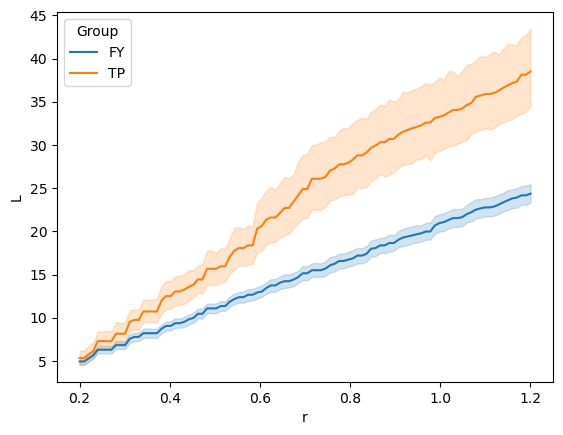

In [22]:
import seaborn as sns
sns.lineplot(data=df3[df3["Rep"]==1], x="r",y="L",hue="Group")

In [9]:
gdf = pd.concat([df3.groupby(["CID","Stack"])["L"].sum(),df3.groupby(["CID","Stack"])["Group"].first()],axis=1)
gdf.head()

L Group
CID Stack                   
2   0      1524.474836    FY
    1      1364.830027    FY
    2      1331.963179    FY
    3      1290.992615    FY
    4      1364.402067    FY

In [10]:
gdf.groupby("Group").mean()

,L
Group,
FY,1363.435372
TP,1848.060387
X,1433.638963


<AxesSubplot:xlabel='Group', ylabel='L'>

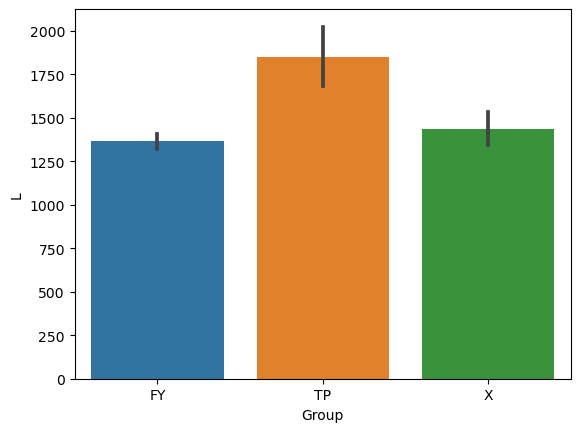

In [11]:
sns.barplot(data=gdf,x="Group",y="L")

In [23]:
gdf2 = pd.concat([df3.groupby(["Group","r"])["L"].mean(),df3.groupby(["Group","r"])["L"].std(),df3.groupby(["Group","r"])["Group"].first(),df3.groupby(["Group","r"])["r"].first()],axis=1)
gdf2.head()

L         L Group         r
Group r                                           
FY    0.200000  4.412694  2.925094    FY  0.200000
      0.210101  4.412694  2.925094    FY  0.210101
      0.220202  4.692620  3.018005    FY  0.220202
      0.230303  5.065833  3.082944    FY  0.230303
      0.240404  5.636199  3.212229    FY  0.240404

<AxesSubplot:>

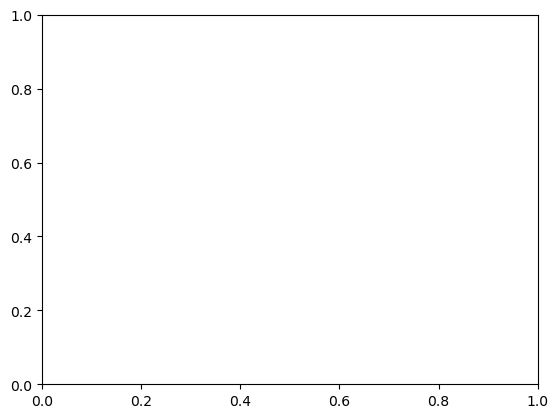

In [13]:
sns.lineplot(data=gdf2.dropna(), x="r",y="L",hue="Group")

In [14]:
import scipy.stats as stats

# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(gdf[gdf["Group"]=="X"]['L'].dropna(), gdf[gdf["Group"]=="TP"]['L'].dropna(), gdf[gdf["Group"]=="FY"]['L'].dropna())
print(fvalue, pvalue)

19.881939910824308 3.3648752035917764e-09


In [15]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

m_comp = pairwise_tukeyhsd(endog=gdf['L'].dropna(), groups=gdf['Group'].dropna(), alpha=0.05)
m_comp.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
FY,TP,484.625,0.0,292.2146,677.0354,True
FY,X,70.2036,0.6752,-124.8293,265.2365,False
TP,X,-414.4214,0.0,-613.7868,-215.0561,True


[] []
0.5
1.0


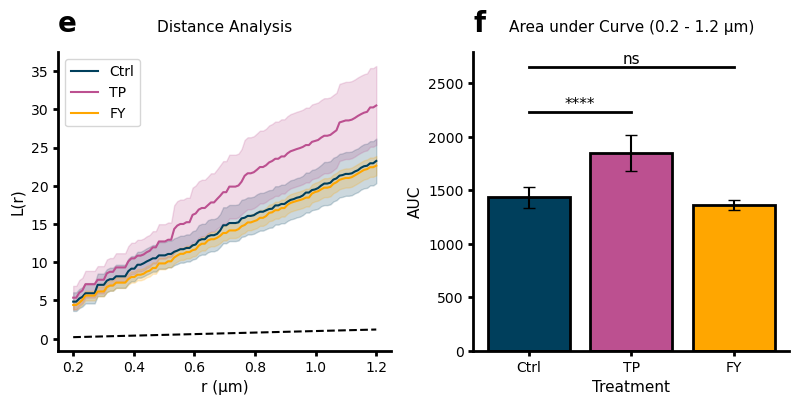

In [79]:
import pathophys as pp

def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def drawsigbars(ax, ctrl, treatment, maxv, y_range, diff,pv):
    import matplotlib.pyplot as plt
    import pathophys as pp
    ctrls = ctrl
    treatments = treatment
    if (type(ctrl) is dict) == True:
        ctrls = list(ctrl.keys())[0]
        ctrl = ctrl[ctrls]
        treatments = list(treatment.keys())[0]
        treatment = treatment[treatments]
        print(ctrl)
    ax.plot(
        [ctrl, ctrl, treatment, treatment],
        [maxv, maxv, maxv, maxv], lw=2, c='k'
    )
    p = pp.convert_pvalue_to_asterisks(pv)
    ax.text((ctrl+diff), maxv, p, ha='center', va='bottom', fontsize=11)

    
pv = {
    "Ctrl":{
        "TP":0,
        "FY":0.6752
    }
}
sigp = [["Ctrl","TP"],["Ctrl","FY"]]
params = pp.loadparams()
#sns.set_palette(sns.color_palette(params["Colors"]))
bs = params["BarSize"]
ls = params["LS"]
fig = plt.figure(constrained_layout=True, figsize=(20*pp.cm,10*pp.cm))
subfigs = fig.subfigures(1,2)

axUp = subfigs[0].subplots(1, 1, sharey=True)

r = df3.groupby(["r"])["r"].first().values
axUp.plot(r, r,linestyle="--",color="black")
i = 0
leg = []
for g in ['X','TP', 'FY']:
    gdf = df3[df3["Group"]==g]
    x = gdf.groupby(["Group","r"])["r"].first().values
    y = gdf.groupby(["Group","r"])["L"].mean().values
    std = gdf.groupby(["Group","r"])["L"].std().values
    err = 1.96*(std)/np.sqrt(std.size)
    line, = axUp.plot(x, y,c=params["Colors"][i])
    leg.append(line)
    axUp.fill_between(x,y-err,y+err,color=params["Colors"][i],alpha=0.2)
    #leg.append(axUp.scatter(x,y,c=params["Colors"][i],marker="^",s=100))
    #leg.append(axUp.errorbar(x, y, xerr=[x-(errlo-reg.intercept_)/float(reg.coef_),(errup-reg.intercept_)/float(reg.coef_)-x], fmt="^",ecolor=params["Colors"][i],ms=10,mec=params["Colors"][i]))
    i = i+1
for axis in ['top','bottom','left','right']:
    axUp.spines[axis].set_linewidth(ls)
    if axis in ['top','right']:
        axUp.spines[axis].set_visible(False)
axUp.tick_params(width=ls)
handles, labels = axUp.get_legend_handles_labels()
print(handles, labels)
axUp.legend(leg,['Ctrl','TP', 'FY'])
axUp.set_title("Distance Analysis", fontsize=11)
axUp.set_title("e", loc="left", fontsize=20, fontweight="bold", pad=15)
axUp.set_xlabel("r (µm)", fontsize=11)
axUp.set_ylabel("L(r)", fontsize=11)

axLo = subfigs[1].subplots(1, 1, sharey=True)
X2 = []
X3 = []
Y2 = []
maxvs = []
i = 0
for g in ['X','TP', 'FY']:
    gdf = df3[df3["Group"]==g].groupby(["CID","Stack"])["L"].sum()
    x = g
    if g == "X":
        x = "Ctrl"
    X2.append(x)
    y = gdf.mean()
    std = gdf.std()
    err = 1.96*(std)/np.sqrt(gdf.size)
    maxvs.append(y+err)
    axLo.bar(x, y, 0.8, yerr=err, capsize=4, linewidth=ls, edgecolor="black",color=params["Colors"][i])
    i=i+1
    #CI1.append(1.96*(df["Mean"][df["Group"]==g].std())/math.sqrt(len(df[df["Group"]==g])))
for axis in ['top','bottom','left','right']:
    axLo.spines[axis].set_linewidth(ls)
    if axis in ['top','right']:
        axLo.spines[axis].set_visible(False)
axLo.tick_params(width=ls)
maxv2 = np.max(np.array(maxvs))

bottom2, top2 = axLo.get_ylim()
y_range = top2 - bottom2
hightind =  y_range*0.1
treatmenti = 0
#args = [df["Mean"][df["Group"]==g].values for g in df["Group"].unique()]
#m_comp = tukey_hsd(*args)
for pairs in sigp:
    c1 = pairs[0]
    ctrli = X2.index(c1)
    c2 = pairs[1]
    treatmenti = X2.index(c2)
    c1dic = {c1:ctrli+1}
    c2dic = {c2:treatmenti+1}
    diff = ((treatmenti-ctrli)/2)
    print(diff)
    p = pv[c1][c2]
    drawsigbars(axLo, ctrli, treatmenti, maxv2+hightind, y_range, diff,p)
    hightind = hightind + y_range*0.2
#expected = ((1.2)**2)/2-((0.2)**2)/2
#axLo.axhline(y=expected, color='r', linestyle='--')
axLo.set_title("Area under Curve (0.2 - 1.2 µm)", fontsize=11)
axLo.set_title("f", loc="left", fontsize=20, fontweight="bold", pad=15)
axLo.set_xlabel("Treatment", fontsize=11)
axLo.set_ylabel("AUC", fontsize=11)


plt.show()